## BalanceNet prototype

In [1]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[+] Using Keras version 2.1.4
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)
[i] Number of entries in each category:
[+] Training:
 [ 7674. 13095. 12740.  3434.   888.]
[+] Validation:
 [1969. 3202. 3198.  867.  221.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...Completed!
Finished running setup.


In [2]:
# second embedding matrix for non-static channel
'''embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()'''
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Done.
[+] Proceeding with Embedding Matrix...Completed!


In [3]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [4]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [5]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [6]:

l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [7]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [8]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [9]:
!rm -r logs

In [10]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [11]:
model.summary()
model.save('BalanceNet.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [12]:
# model = keras.models.load_model("checkpoint-0.94.h5")

Time to train!!

In [13]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=160,
          callbacks=[tensorboard, model_checkpoints])

pandas.DataFrame(model_log.history).to_csv("history-balance.csv")

Training Progress:
Train on 37831 samples, validate on 9457 samples
Epoch 1/100
37831/37831 [==============================] - 161s 4ms/step - loss: 1.2396 - acc: 0.4475 - val_loss: 1.0844 - val_acc: 0.5532
Epoch 2/100
37831/37831 [==============================] - 154s 4ms/step - loss: 1.0662 - acc: 0.5535 - val_loss: 1.0166 - val_acc: 0.5906
Epoch 3/100
37831/37831 [==============================] - 154s 4ms/step - loss: 1.0023 - acc: 0.5862 - val_loss: 0.9850 - val_acc: 0.5964
Epoch 4/100
37831/37831 [==============================] - 154s 4ms/step - loss: 0.9725 - acc: 0.5991 - val_loss: 0.9586 - val_acc: 0.6125
Epoch 5/100
37831/37831 [==============================] - 154s 4ms/step - loss: 0.9494 - acc: 0.6122 - val_loss: 0.9444 - val_acc: 0.6151
Epoch 6/100
37831/37831 [==============================] - 154s 4ms/step - loss: 0.9401 - acc: 0.6158 - val_loss: 0.9412 - val_acc: 0.6168
Epoch 7/100
37831/37831 [==============================] - 154s 4ms/step - loss: 0.9291 - acc: 0.6

KeyboardInterrupt: 

## Model Testing and Inference

In [14]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "happy", "sad", "hate","anger"]

In [15]:
! ls

architectures	      checkpoint-1.08.h5    ProcessData-Crawled.ipynb
BalanceNet-1.0.ipynb  ClassMerge.ipynb	    ProcessData.ipynb
BalanceNet.h5	      _config.yml	    raw_data
checkpoint-0.91.h5    data.bak.csv	    README.md
checkpoint-0.92.h5    data.csv		    run_tensorboard.sh
checkpoint-0.93.h5    dataset		    Setup.ipynb
checkpoint-0.94.h5    experiments	    sklearn_experiments
checkpoint-0.96.h5    ExtraFunctions.ipynb  tokenizer.pickle
checkpoint-0.99.h5    images		    twitter_crawl.py
checkpoint-1.02.h5    logs


In [16]:
model_test = load_model('checkpoint-0.91.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [17]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

             precision    recall  f1-score   support

    neutral       0.48      0.41      0.44      1969
      happy       0.65      0.68      0.66      3202
        sad       0.62      0.68      0.65      3198
       hate       0.80      0.67      0.73       867
      anger       0.91      0.67      0.77       221

avg / total       0.62      0.62      0.62      9457



Normalized confusion matrix
[[4.10360589e-01 2.88471305e-01 2.91518537e-01 9.14169629e-03
  5.07872016e-04]
 [1.44597127e-01 6.75202998e-01 1.71143036e-01 8.11992505e-03
  9.36914428e-04]
 [1.10381488e-01 1.73545966e-01 6.83864916e-01 3.00187617e-02
  2.18886804e-03]
 [5.53633218e-02 4.61361015e-02 2.19146482e-01 6.74740484e-01
  4.61361015e-03]
 [3.61990950e-02 5.88235294e-02 1.94570136e-01 3.61990950e-02
  6.74208145e-01]]


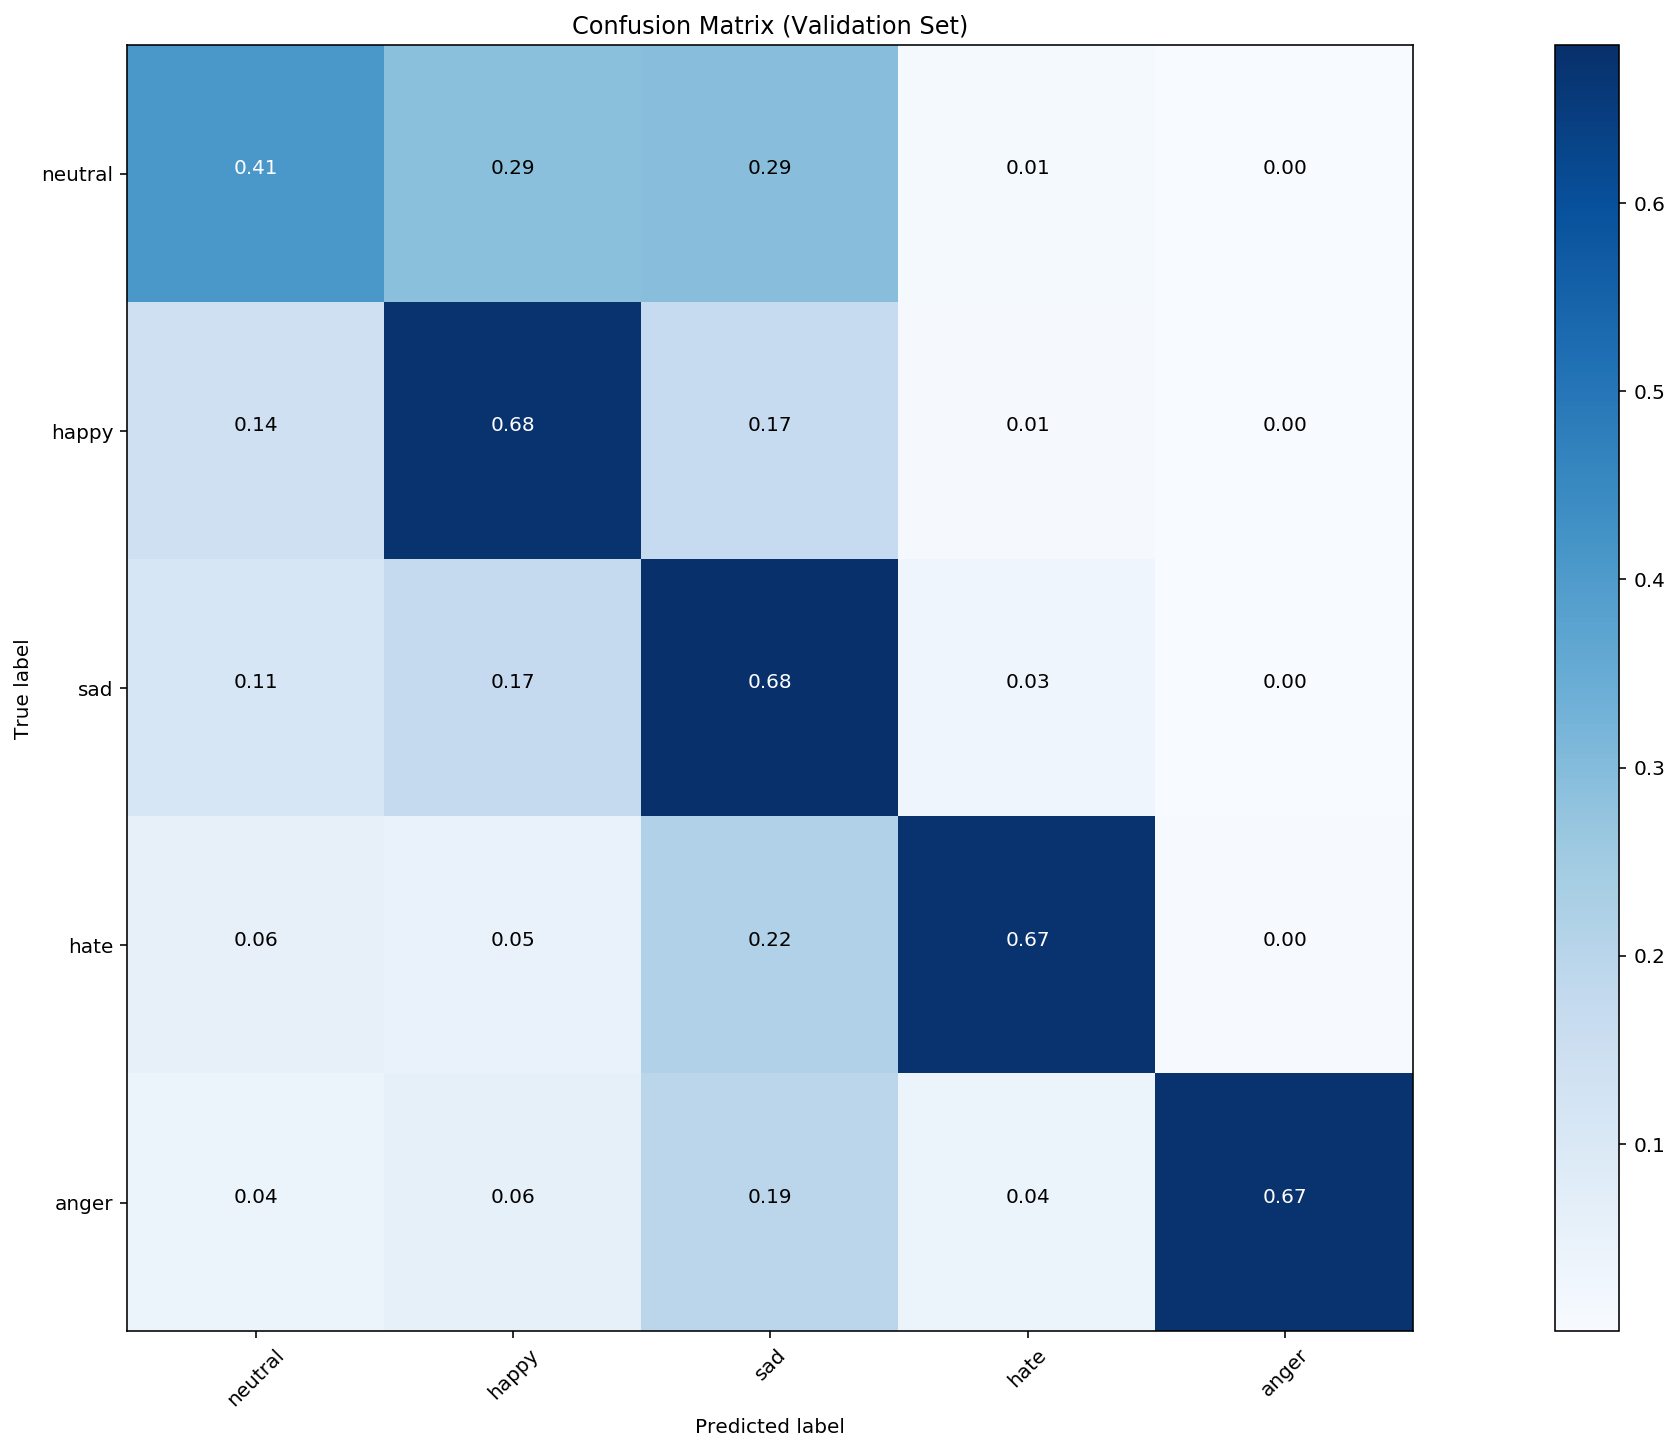

In [18]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [30]:
text = ["Haha look at all u dumbos cant read premium articles, im gonna becum premium nao to read their quality unbiased journalism",
        "ST really need to wake up.",
        "For fuck’s sake - news, stop calling it a machine. It was a guy in a fucking box. Like that then glory hole macam innovative blowjob machine.",
        "Truly I said, we are so greatly divided in this world. Indeed money can do wonder, no one can deny it. Don't remind me, I know I'm still the loser.",
        "Wah gd deal. No much peepor there almost like whole area to urself. And if prepper still got boat for escape. Hope i win 2mr toto, HUAT ARH!!!!!",
        "Don't use NO ENTRY ... CHANGE it NO USE useless Where all the lau kong ... Still CNY mood POWER",
        "Billions of money spent end up become the words 'unable to find out what's wrong with the system'",
        "Sack the whole fucking cabinet",
        "Dun need give birth ?? Come in PRC ok Liao",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [31]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model_test.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

Haha look at all u dumbos cant read premium articles, im gonna becum premium nao to read their quality unbiased journalism 
Prediction: neutral 

ST really need to wake up. 
Prediction: sad 

For fuck’s sake - news, stop calling it a machine. It was a guy in a fucking box. Like that then glory hole macam innovative blowjob machine. 
Prediction: hate 

Truly I said, we are so greatly divided in this world. Indeed money can do wonder, no one can deny it. Don't remind me, I know I'm still the loser. 
Prediction: sad 

Wah gd deal. No much peepor there almost like whole area to urself. And if prepper still got boat for escape. Hope i win 2mr toto, HUAT ARH!!!!! 
Prediction: happy 

Don't use NO ENTRY ... CHANGE it NO USE useless Where all the lau kong ... Still CNY mood POWER 
Prediction: sad 

Billions of money spent end up become the words 'unable to find out what's wrong with the system' 
Prediction: sad 

Sack the whole fucking cabinet 
Prediction: hate 

Dun need give birth ?? Come in